# Reporte de práctica 13: Análisis de imágenes

Para esta práctica se tomarán en cuenta los ganadores de las seis categorías disponibles para el concurso de Colombia en el año 2018. Contamos con los videos ganadores en la plataforma de YouTube, todos en alta calidad. Se necesitan hacer análisis sobre las imágenes que obtendremos de los fotogramas de los videos.

## Objetivo

- Aplicar algún tipo de procesamiento de imágenes.

## Datos

### "Base de datos completa" de los registros al concurso de SmartFilm.

En este caso, es necesario limpiar los datos, seleccionaremos los registros que concuerden con el nombre de los videos ganadores por categoría.

De la base de datos tomaremos los siguientes campos para trabajar:

 - Categoría
 - Edad
 - País
 - Título del Corto
 - Género
 - Duración
 - Marca
 - Referencia Celular
 - Días de rodaje
 - Marcas del rodaje
 - Personas


### Contamos con 6 videos en resolución 1920 x 1080 pixeles sin audio formato mp4.

Los videos ganadores son los siguientes:

|Categoría|Título|
|---|---|
|Aficionado|[EZEQUIEL 18:27](https://www.youtube.com/watch?v=qx8wACV3Wyc)|
|Crónica|[Mil colores para mi pueblo, Arte para la paz.](https://www.youtube.com/watch?v=SdYrUJ1vo_I)|
|Familiar|[Ellos](https://www.youtube.com/watch?v=MBtZc9HOFsM)|
|Juvenil|[La Otra Cara de Karla](https://www.youtube.com/watch?v=H_4QW3xdf5w)|
|Profesional|[Una última vez](https://www.youtube.com/watch?v=_67Y-K7ASDk)|
|SmarTIC|[Sin Ataduras 1812](https://www.youtube.com/watch?v=FLofpshTn8k)|

De cada video tomaremos todos los fotogramas para procesarlos. 

## Hipótesis

### Para Imágenes
Para separar las transiciones relevantes de posibles cambios de iluminación en el video, haremos un clasificador sencillo, si la transición está por encima de la media de todas las transiciones, quiere decir no es un simple cambio de iluminación.

### Imágenes contra datos
La cantidad de transiciones está relacionada con la cantidad de días de rodaje.

## Método 

La forma en la que analizaremos los videos será tomando un fotograma (fotograma base) y comparándolo con los dos contiguos (prueba 1 y 2). Utilizaremos [OpenCV](https://opencv.org/) para el tratamiento de las imágenes, compararemos histogramas. Convertiremos los colores de la imagen de RGB a HSV para trabajar tal como lo muestra el [tutorial](https://docs.opencv.org/master/d8/dc8/tutorial_histogram_comparison.html). Utilizamos  el método de comparación Chi cuadrada ya que si uno de los fotogramas de prueba es completamente diferente al fotograma base los valores que arroja son significativamente altos, indicando una transición de escena en el video.

Compararemos la cantidad de transiciones se relaciona con los días de rodaje.

Se crearon dos clases en Python para procesar los videos y después los fotogramas.

- Extract_frames
- Hist_comparison

Se muestran a continuación.


#### Clase Extract_frames.py

In [ ]:
import cv2
import os
from console_progressbar import ProgressBar


class Extract_frames:

    def __init__(self,filename,segundos=300):
        self.vidcap = cv2.VideoCapture(filename)
        success,image = self.vidcap.read()
        self.success = success
        self.image = image
        self.filename = filename[:-4]
        self.segundos = segundos
        fps = self.vidcap.get(cv2.CAP_PROP_FPS)
        self.Numframes = segundos*fps
        self.getFrames()

    def getFrames(self):
        try:
            os.stat(self.filename)
        except:
            os.mkdir(self.filename)
        print('\n'+"Leyendo: " + self.filename)
        pb = ProgressBar(total=self.Numframes, prefix='Progreso:', suffix = 'frames', decimals=2, length=50)
        count = 0
        while self.success:
            cv2.imwrite(self.filename+"/frame%d.jpg" % count, self.image)    
            success,image = self.vidcap.read()
            self.success = success
            self.image = image
            count += 1
            pb.print_progress_bar(count)
        pb.print_progress_bar(self.Numframes)

aficionado = Extract_frames('aficionado2018.mp4')
cronica = Extract_frames('cronica2018.mp4')
familiar = Extract_frames('familiar2018.mp4')
juvenil = Extract_frames('juvenil2018.mp4')
profesional = Extract_frames('profesional2018.mp4')
smarTIC = Extract_frames('smartic2018.mp4')

#### Clase Hist_comparison.py

In [ ]:
import cv2 as cv
import numpy as np


class Hist_comparison:

    def __init__(self,base,t1,t2):
        self.base = base
        src_base = cv.imread(self.base)
        src_test1 = cv.imread(t1)
        src_test2 = cv.imread(t2)
        if src_base is None or src_test1 is None or src_test2 is None:
            print('Could not open or find the images!')
            exit(0)
        self.hsv_base = cv.cvtColor(src_base, cv.COLOR_BGR2HSV)
        self.hsv_test1 = cv.cvtColor(src_test1, cv.COLOR_BGR2HSV)
        self.hsv_test2 = cv.cvtColor(src_test2, cv.COLOR_BGR2HSV)
        h_bins = 50
        s_bins = 60
        self.histSize = [h_bins, s_bins]
        # hue varies from 0 to 179, saturation from 0 to 255
        h_ranges = [0, 180]
        s_ranges = [0, 256]
        self.ranges = h_ranges + s_ranges # concat lists
        # Use the 0-th and 1-st channels
        self.channels = [0, 1]
        self.base_base = None
        self.base_test1 = None
        self.base_test2 = None
        self.doComparison()

    def doComparison(self):
        hist_base = cv.calcHist([self.hsv_base], self.channels, None, self.histSize, self.ranges, accumulate=False)
        cv.normalize(hist_base, hist_base, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
        hist_test1 = cv.calcHist([self.hsv_test1], self.channels, None, self.histSize, self.ranges, accumulate=False)
        cv.normalize(hist_test1, hist_test1, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
        hist_test2 = cv.calcHist([self.hsv_test2], self.channels, None, self.histSize, self.ranges, accumulate=False)
        cv.normalize(hist_test2, hist_test2, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
        compare_method = 1
        self.base_test1 = cv.compareHist(hist_base, hist_test1, compare_method)
        self.base_test2 = cv.compareHist(hist_base, hist_test2, compare_method)
        
    def getValues(self,filename):
        print(self.base[5:-4],self.base_test1,self.base_test2, file=open(filename, "a"))



from console_progressbar import ProgressBar
import glob

totImages=len(glob.glob("*.jpg"))

print('Procesando: ' + str(totImages) + ' frames')
pb1 = ProgressBar(total=totImages, prefix='Progreso:', suffix = 'frames', decimals=2, length=50)
for i in range(0,totImages-2):
    HC = Hist_comparison('frame'+str(i)+'.jpg','frame'+str(i+1)+'.jpg','frame'+str(i+2)+'.jpg')
    HC.getValues("frames.csv")
    pb1.print_progress_bar(i)
pb1.print_progress_bar(totImages)

print('Procesando: ' + str(300) + ' segundos')
pb24 = ProgressBar(total=totImages, prefix='Progreso:', suffix = 'segundos', decimals=2, length=50)
step=int(totImages/300)
for i in range(0,totImages-2,step):
    HC = Hist_comparison('frame'+str(i)+'.jpg','frame'+str(i+int(step/2))+'.jpg','frame'+str(i+step)+'.jpg')
    HC.getValues("seconds.csv")
    pb24.print_progress_bar(i)
pb24.print_progress_bar(totImages)

## Grafica de diferencias

Se utiliza Plotly para graficar los .csv de referencia que fueron producidos para verificar visualmente las transiciones.

In [1]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as FF

import numpy as np
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/SamatarouKami/CIENCIA_DE_DATOS/master/old/P13csv/framesP.csv',sep=' ')

df.columns = ['frame','test1','test2']

df['diferencia'] = df.test2 - df.test1

df.diferencia = df.diferencia.apply(np.sqrt).apply(np.sqrt)

df = df.dropna()


df2 = pd.read_csv('https://raw.githubusercontent.com/SamatarouKami/CIENCIA_DE_DATOS/master/old/P13csv/secondsP.csv',sep=' ')

df2.columns = ['frame','test1','test2']

df2['diferencia'] = df2.test2 - df2.test1

df2.diferencia = df2.diferencia.apply(np.sqrt).apply(np.sqrt)

df2 = df2.dropna()


trace1 = go.Scatter(x = df['frame'], y = df['diferencia'],
                  name='Variaciones por Frame')

trace2 = go.Scatter(x = df2['frame'], y = df2['diferencia'],
                  name='Variaciones por segundo')

layout = {
    'title': "Transiciones medidas por variación de Histogramas",
    'shapes': [
        {
            'type': 'line',
            'x0': 1,
            'y0': 2,
            'x1': 7200,
            'y1': 2,
            'opacity': 0.7,
            'line': {
                'color': 'red',
                'width': 2.5,
            },
        },
    ]
}

fig = go.Figure(data=[trace1,trace2], layout=layout)

py.iplot(fig, filename='P13')

En esta gráfica se busca demostrar como se sabia el número de transiciones de los videos ya que donde se encuentran los picos más altos, significa un cambio radical en la escena. La línea roja representa el umbral de que debe pasar una transición para no ser considerada cambio de brillo.

## Preparación

Primero preparamos el DataFrame de la base de datos.

In [6]:
import pandas as pd
df2018 = pd.read_excel('2018.xlsx', index_col=None, header=0, sheet_name=0)
df2018 = df2018[['Categoria','Edad','Pais', 'Titulo','Genero', 'Duracion', 'Marca','Referencia','Dias','Marcas','Personas']]
#print(df2018.columns)

ganadores = ['EZEQUIEL 18:27','Mil colores para mi pueblo, Arte para la paz.','Ellos','La Otra Cara de Karla','Una última vez','Sin Ataduras 1812']

df2018 = df2018.loc[df2018['Titulo'].isin(ganadores)]
df2018 = df2018.sort_values(by='Categoria').reset_index()

print(df2018)

   index           Categoria  Edad      Pais  \
0    175          AFICIONADO    19  Colombia   
1    294            CRONICAS    31  Colombia   
2    156            FAMILIAR    21  Colombia   
3    234             JUVENIL    16  Colombia   
4    381  SMARTIC INCLUYENTE    29  Colombia   

                                          Titulo   Genero  Duracion    Marca  \
0                                 EZEQUIEL 18:27    Drama       299    Apple   
1  Mil colores para mi pueblo, Arte para la paz.  Crónica       300  Samsung   
2                                          Ellos    Drama       290    Apple   
3                          La Otra Cara de Karla     Otra     27423  Samsung   
4                              Sin Ataduras 1812    Drama       298  Samsung   

       Referencia  Dias   Marcas  Personas  
0        ¡Phone 7   155    154.0        15  
1  Galaxy s6 Edge    30      NaN         6  
2         iPhone8    60    172.0        20  
3             S9+    40  20899.0        35  
4    

Como la extracción de frames de los videos agranda el volumen de archivos con los cuales trabajar, se aplicó el método en los videos fuera de linea. Se obtuvieron doce archivos, emparejados representan un video, el primero es la comparación de todos los frames, y el segundo es la comparación de los frames revisando cada cierta cantidad de frames, dada por el "fps rate".

|Video|Archivos||
|---|---|---|
|EZEQUIEL 18:27|framesA.csv|secondsA.csv|
|Mil colores para mi pueblo, Arte para la paz.|framesC.csv|secondsC.csv|
|Ellos|framesF.csv|secondsF.csv|
|La Otra Cara de Karla|framesJ.csv|secondsJ.csv|
|Una última vez|framesP.csv|secondsP.csv|
|Sin Ataduras 1812|framesS.csv|secondsS.csv|


Ahora que tenemos los datos del análisis de imágenes podemos calcular sus transiciones.

In [3]:
import numpy as np

framesA = pd.read_csv('old/P13csv/framesA.csv', sep=' ', index_col =0)
framesA.set_axis(['Test1','Test2'], axis='columns', inplace=True)
framesA['Diferencia'] = framesA['Test2']-framesA['Test1']
framesA['Transicion'] = np.where(framesA["Diferencia"]>framesA["Diferencia"].mean(), 1, 0 )

secondsA = pd.read_csv('old/P13csv/secondsA.csv', sep=' ', index_col =0)
secondsA.set_axis(['Test1','Test2'], axis='columns', inplace=True)
secondsA['Diferencia'] = secondsA['Test2']-secondsA['Test1']
secondsA['Transicion'] = np.where(secondsA["Diferencia"]>secondsA["Diferencia"].mean(), 1, 0 )


framesC = pd.read_csv('old/P13csv/framesC.csv', sep=' ', index_col =0)
framesC.set_axis(['Test1','Test2'], axis='columns', inplace=True)
framesC['Diferencia'] = framesC['Test2']-framesC['Test1']
framesC['Transicion'] = np.where(framesC["Diferencia"]>framesC["Diferencia"].mean(), 1, 0 )

secondsC = pd.read_csv('old/P13csv/secondsC.csv', sep=' ', index_col =0)
secondsC.set_axis(['Test1','Test2'], axis='columns', inplace=True)
secondsC['Diferencia'] = secondsC['Test2']-secondsC['Test1']
secondsC['Transicion'] = np.where(secondsC["Diferencia"]>secondsC["Diferencia"].mean(), 1, 0 )


framesF = pd.read_csv('old/P13csv/framesF.csv', sep=' ', index_col =0)
framesF.set_axis(['Test1','Test2'], axis='columns', inplace=True)
framesF['Diferencia'] = framesF['Test2']-framesF['Test1']
framesF['Transicion'] = np.where(framesF["Diferencia"]>framesF["Diferencia"].mean(), 1, 0 )

secondsF = pd.read_csv('old/P13csv/secondsF.csv', sep=' ', index_col =0)
secondsF.set_axis(['Test1','Test2'], axis='columns', inplace=True)
secondsF['Diferencia'] = secondsF['Test2']-secondsF['Test1']
secondsF['Transicion'] = np.where(secondsF["Diferencia"]>secondsF["Diferencia"].mean(), 1, 0 )

framesJ = pd.read_csv('old/P13csv/framesJ.csv', sep=' ', index_col =0)
framesJ.set_axis(['Test1','Test2'], axis='columns', inplace=True)
framesJ['Diferencia'] = framesJ['Test2']-framesJ['Test1']
framesJ['Transicion'] = np.where(framesJ["Diferencia"]>framesJ["Diferencia"].mean(), 1, 0 )

secondsJ = pd.read_csv('old/P13csv/secondsJ.csv', sep=' ', index_col =0)
secondsJ.set_axis(['Test1','Test2'], axis='columns', inplace=True)
secondsJ['Diferencia'] = secondsJ['Test2']-secondsJ['Test1']
secondsJ['Transicion'] = np.where(secondsJ["Diferencia"]>secondsJ["Diferencia"].mean(), 1, 0 )

framesP = pd.read_csv('old/P13csv/framesP.csv', sep=' ', index_col =0)
framesP.set_axis(['Test1','Test2'], axis='columns', inplace=True)
framesP['Diferencia'] = framesP['Test2']-framesP['Test1']
framesP['Transicion'] = np.where(framesP["Diferencia"]>framesP["Diferencia"].mean(), 1, 0 )

secondsP = pd.read_csv('old/P13csv/secondsP.csv', sep=' ', index_col =0)
secondsP.set_axis(['Test1','Test2'], axis='columns', inplace=True)
secondsP['Diferencia'] = secondsP['Test2']-secondsP['Test1']
secondsP['Transicion'] = np.where(secondsP["Diferencia"]>secondsP["Diferencia"].mean(), 1, 0 )

framesS = pd.read_csv('old/P13csv/framesS.csv', sep=' ', index_col =0)
framesS.set_axis(['Test1','Test2'], axis='columns', inplace=True)
framesS['Diferencia'] = framesS['Test2']-framesS['Test1']
framesS['Transicion'] = np.where(framesS["Diferencia"]>framesS["Diferencia"].mean(), 1, 0 )

secondsS = pd.read_csv('old/P13csv/secondsS.csv', sep=' ', index_col =0)
secondsS.set_axis(['Test1','Test2'], axis='columns', inplace=True)
secondsS['Diferencia'] = secondsS['Test2']-secondsS['Test1']
secondsS['Transicion'] = np.where(secondsS["Diferencia"]>secondsS["Diferencia"].mean(), 1, 0 )

trans=[]

trans.append([framesA['Transicion'].sum(),secondsA['Transicion'].sum()])
trans.append([framesC['Transicion'].sum(),secondsC['Transicion'].sum()])
trans.append([framesF['Transicion'].sum(),secondsF['Transicion'].sum()])
trans.append([framesJ['Transicion'].sum(),secondsJ['Transicion'].sum()])
trans.append([framesP['Transicion'].sum(),secondsP['Transicion'].sum()])
trans.append([framesS['Transicion'].sum(),secondsS['Transicion'].sum()])

#print(trans)

df = pd.DataFrame(data=trans)

df.set_axis(['frames','seconds'], axis='columns', inplace=True)


df2018['id']=df2018.index
df['id']=df.index

dfFinal = pd.merge(df2018, df)

dfFinal = dfFinal.drop(['id','index'], axis=1)

#print(dfFinal)
e = dfFinal

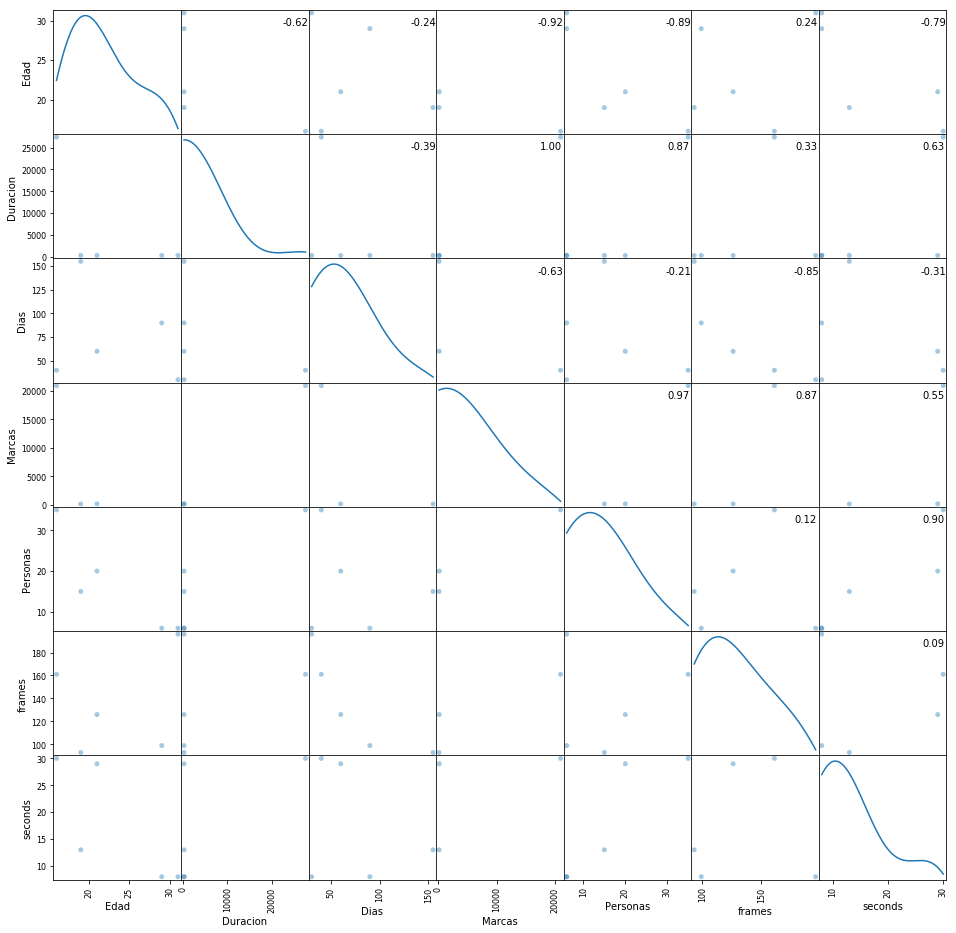

In [5]:
import pandas as pd
from numpy import NaN
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

ax = scatter_matrix(e, alpha = 0.4, figsize = (16, 16), diagonal = 'kde', s = 100)
c = e.corr().values
for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
    ax[i, j].annotate('{:.2f}'.format(c[i, j]), (0.9, 0.9), \
                      xycoords = 'axes fraction', ha = 'center', va = 'center')
plt.show()

## Conclusión

Son muy pocos datos para obtener una gráfica con más puntos, pero revisando los coeficientes, se puede comprobar que la duración y las marcas están relacionadas y también las marcas con la cantidad de transiciones. Así que damos por probada la hipótesis de Imagen contra datos.

--06 de junio 2019-- Luis Angel Gutiérrez Rodríguez 1484412